# Multirotor Dynamic Model

$M_b = J \dot{\omega_b} + \omega_b \times (J \omega_b)$

$\dot{\omega_b} = J^{-1}(M_b - \omega_b \times (J \omega_b))$

$F_b = m \dot{v_b} + \omega_b \times (m v_b)$

$\dot{v_b} = F_b/m -  \omega_b \times v_b$

In [1]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
import control
import collections
import sys
sys.path.insert(0, '../python/pyecca')
import pyecca.lie.so3 as so3
np.set_printoptions(suppress=True, precision=3, linewidth=200)

In [2]:
def create_name_index(x):
    name = {}
    index = {}
    n = x.shape[0]
    for i in range(n):
        name[i] = x[i].name()
        index[x[i].name()] = i
    return name, index

In [3]:
def quadrotor_model():
    # state space model
    
    #x: state: (position, orientation, velocity (body frame), angular velocity (body frame))
    P = ca.SX.sym('P')
    Q = ca.SX.sym('Q')
    R = ca.SX.sym('R')
    omega_b = ca.vertcat(P, Q, R)
    v_b = ca.SX.sym('v_b', 3)
    r_nb = ca.SX.sym('r_nb', 4)
    p_b = ca.SX.sym('p_b', 3)
    rpm = ca.SX.sym('rpm', 4)
    x = ca.vertcat(p_b, r_nb, omega_b, v_b, rpm)
    x_name, x_id = create_name_index(x)

    #u: control
    u_roll = ca.SX.sym('u_roll')
    u_pitch = ca.SX.sym('u_pitch')
    u_yaw = ca.SX.sym('u_yaw')
    u_thrust = ca.SX.sym('u_thrust')
    u = ca.vertcat(u_roll, u_pitch, u_yaw, u_thrust)
    u_name, u_id = create_name_index(u)

    # p: parameters
    m = ca.SX.sym('m')  # mass
    l = ca.SX.sym('l')  # arm length
    g = ca.SX.sym('g')  # grav. accel
    tau = ca.SX.sym('tau')  # motor time constant
    rho = ca.SX.sym('rho')  # air density
    r = ca.SX.sym('r')  # prop radius
    Jx = ca.SX.sym('Jx')
    Jy = ca.SX.sym('Jy')
    Jz = ca.SX.sym('Jy')
    Jxz = ca.SX.sym('Jxz')
    V = ca.SX.sym('V')  # battery voltage
    kV = ca.SX.sym('kV')  # motor kV
    CT = ca.SX.sym('CT')  # thrust coefficient
    CM = ca.SX.sym('CM')  # moment coefficient
    p = ca.vertcat(l, m, g, Jx, Jy, Jz, Jxz, tau, rho, r, V, kV, CT, CM)
    p_name, p_id = create_name_index(p)

    #y: output, just state for now
    y = x
    y_name, y_id = create_name_index(y)

    J = ca.SX.zeros(3, 3)
    J[0, 0] = Jx
    J[1, 1] = Jy
    J[2, 2] = Jz
    J[0, 2] = J[2, 0] = Jxz

    # forces and moments
    arm_angles_deg = [45, -135, -45, 135]
    motor_dirs = [-1, -1, 1, 1]
    mix_matrix =ca.DM([
        [-1, 1, 1, -1], # roll
        [1, -1, 1, -1], # pitch
        [1, 1, -1, -1], # yaw
        [1, 1, 1, 1] # thrust
    ])
    u_rpm = ca.mtimes(ca.inv(mix_matrix), u)
    C_nb = so3.Dcm.from_mrp(r_nb)
    F_b = ca.mtimes(C_nb.T, ca.vertcat(0, 0, m*g))
    M_b = ca.SX.zeros(3)
    for theta_deg, rpm_i, motor_dir in zip(arm_angles_deg, rpm, motor_dirs):
        theta = theta_deg*ca.pi/180
        omega = rpm_i*V*kV*(2*ca.pi/60)
        q = rho*(omega*r)**2/2
        s = ca.pi*r**2
        arm_b = ca.vertcat(ca.cos(theta), ca.sin(theta), 0)
        Fi_b = ca.vertcat(0, 0, -CT*q*s)
        Mi_b = ca.vertcat(0, 0, -motor_dir*CM*q*s) + ca.cross(arm_b, Fi_b)
        F_b += Fi_b
        M_b += Mi_b

    x_dot = ca.vertcat(
        v_b,
        so3.Mrp.kinematics(r_nb, omega_b),
        ca.mtimes(ca.inv(J), M_b - ca.cross(omega_b, ca.mtimes(J, omega_b))),
        F_b/m - ca.cross(omega_b, v_b),
        (u_rpm - rpm)/tau
    )

    # TODO trim
    u0 = ca.vertcat(0, 1000, 1000, 1000)
    x0 = ca.vertcat(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, u0)
    
    # motor time constant 0.015 s, https://flyingmachinearena.org/wp-content/publications/2014/mueIEEE14.pdf
    p0 = ca.vertcat(1, 1, 9.8, 1, 1, 1, 0.1, 0.015, 1.226, 0.1, 11.1, 1550, 1e-3, 1e-4)
    
    # linearization
    A = ca.jacobian(x_dot, x)
    B = ca.jacobian(x_dot, u)
    C = ca.jacobian(y, x)
    D = ca.jacobian(y, u)
    f_ss = ca.Function('ss', [x, u, p], [A, B, C, D])

    sys = control.ss(*f_ss(x0, u0, p0))
    
    return {
        'sys': sys,
        'x_id': x_id,
        'x_name': x_name,
        'y_id': y_id,
        'y_name': y_name,
        'u_id': u_id,
        'u_name': u_name
    }

In [4]:
model = quadrotor_model()
sys = model['sys']
y_id = model['y_id']
u_id = model['u_id']

# Body Roll Rate Control


        4.444e+04
-------------------------
s^2 + 66.67 s + 1.182e-14

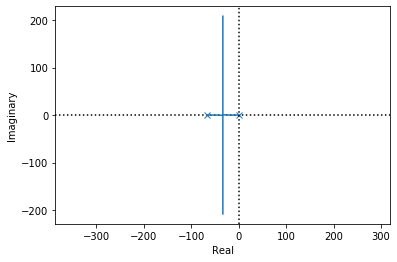

In [5]:
G_roll_rate = control.ss2tf(sys[y_id['P'], u_id['u_roll']])
control.rlocus(G_roll_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_roll_rate

(inf, 65.7390092187895, nan, 57.5567898747984)


<Figure size 432x288 with 0 Axes>

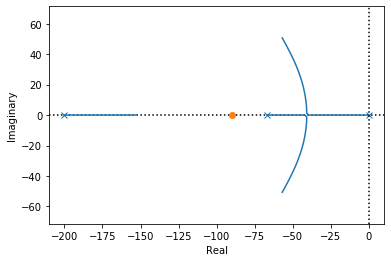

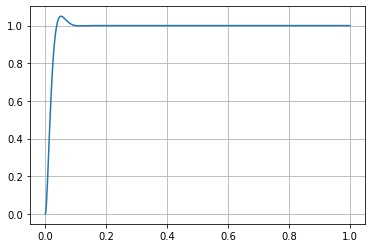

In [6]:
s = control.tf([1, 0], [0, 1])
H_roll_rate = 0.1*(s/90+1)/(s/200 + 1)
Go_roll_rate = G_roll_rate*H_roll_rate
print(control.margin(Go_roll_rate))

plt.figure()
control.rlocus(Go_roll_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_roll_rate = control.feedback(Go_roll_rate)

plt.figure()
t, y = control.step_response(Gc_roll_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()



# Body Roll Control

(4.70208166990585, 62.393158953741874, 92.50418348931574, 30.15053283737778)


<Figure size 432x288 with 0 Axes>

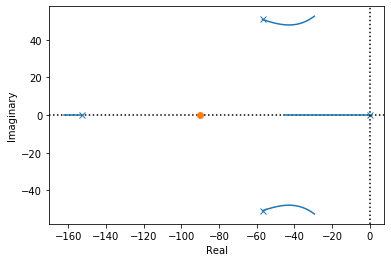

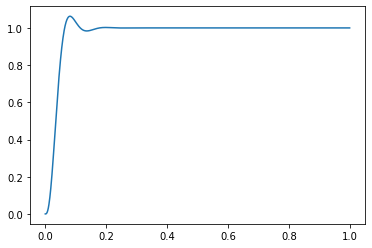

In [7]:
H_roll = 30
G_roll = Gc_roll_rate/s
Go_roll = H_roll*G_roll
Gc_roll = control.feedback(Go_roll)
print(control.margin(Go_roll))

plt.figure()
control.rlocus(Go_roll, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

plt.figure()
t, y = control.step_response(Gc_roll, np.linspace(0, 1, 1000))
plt.plot(t, y)

# Body Yaw Rate Control


          4826
-------------------------
s^2 + 66.67 s + 1.444e-15

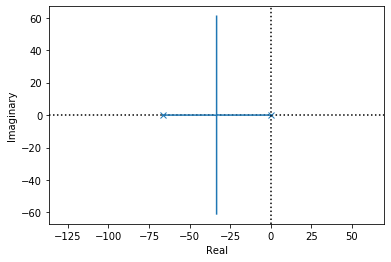

In [8]:
G_yaw_rate = control.ss2tf(sys[y_id['R'], u_id['u_yaw']])
control.rlocus(G_yaw_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_yaw_rate

(inf, 68.05609101011288, nan, 26.859193209101647)


<Figure size 432x288 with 0 Axes>

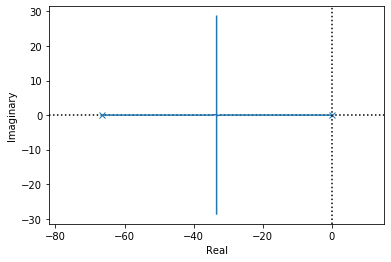

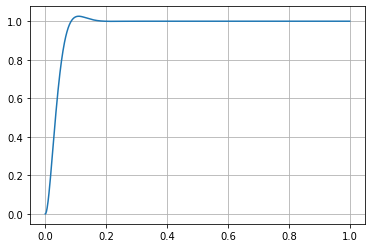

In [9]:
H_yaw_rate = 0.4
Go_yaw_rate = G_yaw_rate*H_yaw_rate
print(control.margin(Go_yaw_rate))

plt.figure()
control.rlocus(Go_yaw_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_yaw_rate = control.feedback(Go_yaw_rate)

plt.figure()
t, y = control.step_response(Gc_yaw_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()

# Body Yaw Control

(4.444444444444441, 60.31810218189804, 43.93717748427727, 14.665835374265757)


<Figure size 432x288 with 0 Axes>

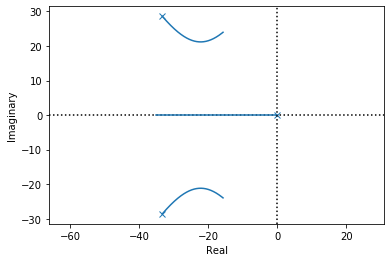

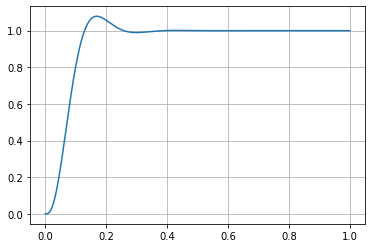

In [10]:
H_yaw = 15
G_yaw = Gc_yaw_rate/s
Go_yaw = G_yaw*H_yaw
print(control.margin(Go_yaw))

plt.figure()
control.rlocus(Go_yaw, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_yaw = control.feedback(Go_yaw)

plt.figure()
t, y = control.step_response(Gc_yaw, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()

# Climb Rate


        6.251e+04
-------------------------
s^2 + 66.67 s - 9.898e-14

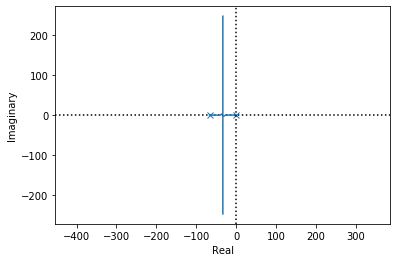

In [11]:
G_climb_rate = control.ss2tf(-sys[y_id['v_b_2'], u_id['u_thrust']])
control.rlocus(G_climb_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')
G_climb_rate

(3.166732006868733e-17, 58.934560169673375, 0.0, 40.16107857990274)


<Figure size 432x288 with 0 Axes>

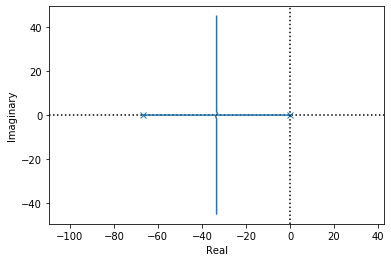

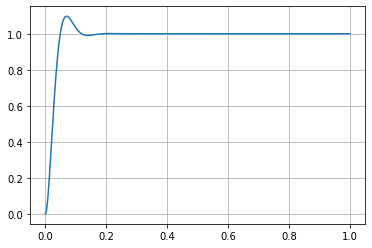

In [12]:
H_climb_rate = 0.05
Go_climb_rate = G_climb_rate*H_climb_rate
print(control.margin(Go_climb_rate))

plt.figure()
control.rlocus(Go_climb_rate, kvect=np.linspace(0, 1, 1000));
plt.axis('equal')

Gc_climb_rate = control.feedback(Go_climb_rate)

plt.figure()
t, y = control.step_response(Gc_climb_rate, T=np.linspace(0, 1, 1000))
plt.plot(t, y)
plt.grid()